# Calculate Number of Frost Days

This notebook computes the annual number of frost days for a given year, by using the daily minimum temperature (`tasmin`). The number of frost days index is the annual count of days where `tasmin` < 0 °C.

This Jupyter notebook is meant to run in the Jupyterhub server of the German Climate Computing Center [DKRZ](https://www.dkrz.de/) which is an [ESGF](https://esgf.llnl.gov/) repository that hosts 4 petabytes of CMIP6 data. Please, choose the Python 3 unstable kernel on the Kernel tab above, it contains all the common geoscience packages. See more information on how to run Jupyter notebooks at DKRZ [here](https://www.dkrz.de/up/systems/mistral/programming/jupyter-notebook). Find there how to run this Jupyter notebook in the DKRZ server out of the Jupyterhub, which will entail that you create the environment accounting for the required package dependencies. Running this Jupyter notebook in your premise, which is also known as [client-side](https://en.wikipedia.org/wiki/Client-side) computing, will also require that you install the necessary packages on you own but it will anyway fail because you will not have direct access to the data pool. Direct access to the data pool is one of the main benefits of the [server-side](https://en.wikipedia.org/wiki/Server-side) data-near computing we demonstrate in this use case.

In this use case you will learn the following:
- How to access a dataset from the DKRZ CMIP6 model data archive
- How to count the annual number of frost days globally for a specified year
- How to visualize the results


You will use:
- [Intake](https://github.com/intake/intake) for finding the data in the catalog of the DKRZ archive
- [Xarray](http://xarray.pydata.org/en/stable/) for loading and processing the data
- [Cartopy](https://pypi.org/project/Cartopy/) for visualizing the data in the Jupyter notebook and save the plots in your local computer

## 0. Import Packages

In [1]:
import intake           # to find data in a catalog, this notebook explains how it works
import xarray as xr     # handling labelled multi-dimensional arrays

# plotting libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

## 1. Select the Year for Frost Days Calculation

In [2]:
year = "2100"

## 2. Intake Catalog
Similar to the shopping catalog at your favorite online bookstore, the intake catalog contains information (e.g. model, variables, and time range) about each dataset (the title, author, and number of pages of the book, for instance) that you can access before loading the data. It means that thanks to the catalog, you can find where is the book just by using some keywords and you do not need to hold it in your hand to know the number of pages, for instance.

### 2.1. Load the Intake Catalog and Orientate
We load the catalog descriptor with the intake package. The catalog is updated daily. The catalog descriptor is created by the DKRZ developers that manage the catalog, you do not need to care so much about it, knowing where it is and loading it is enough:

In [3]:
# Path to catalog descriptor on the DKRZ server
col_url = "/pool/data/Catalogs/mistral-cmip6.json"

# Open the catalog with the intake package and name it "col" as short for "collection"
col = intake.open_esm_datastore(col_url)
col

,unique
activity_id,19
institution_id,39
source_id,100
experiment_id,197
member_id,417
table_id,38
variable_id,1162
grid_label,12
dcpp_init_year,61
version,644


Let's see what is inside the intake catalog. The underlying data base is given as a pandas dataframe which we can access with `col.df`. Hence, `col.df.head()` shows us the first rows of the table of the catalog.

In [6]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c2h6,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
1,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c3h6,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
2,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,c3h8,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
3,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,cdnc,gn,NaN,v20200522,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...
4,AerChemMIP,BCC,BCC-ESM1,hist-piAer,r1i1p1f1,AERmon,ch3coch3,gn,NaN,v20200511,185001-201412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Aer...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/AerCh...


This catalog contains all datasets of the CMIP6 archive at DKRZ. Before searching for the needed data file we will have a closer look at the cataloge.

100 climte models `source_id` are part of the catalog.

In [7]:
col.unique(["source_id"])

{'source_id': {'count': 100,
  'values': ['ACCESS-CM2',
   'ACCESS-ESM1-5',
   'ARTS-2-3',
   'AWI-CM-1-1-HR',
   'AWI-CM-1-1-LR',
   'AWI-CM-1-1-MR',
   'AWI-ESM-1-1-LR',
   'BCC-CSM2-HR',
   'BCC-CSM2-MR',
   'BCC-ESM1',
   'CAMS-CSM1-0',
   'CAS-ESM2-0',
   'CESM1-1-CAM5-CMIP5',
   'CESM1-CAM5-SE-HR',
   'CESM1-CAM5-SE-LR',
   'CESM2',
   'CESM2-FV2',
   'CESM2-WACCM',
   'CESM2-WACCM-FV2',
   'CIESM',
   'CMCC-CM2-HR4',
   'CMCC-CM2-SR5',
   'CMCC-CM2-VHR4',
   'CMCC-ESM2',
   'CNRM-CM6-1',
   'CNRM-CM6-1-HR',
   'CNRM-ESM2-1',
   'CanESM5',
   'CanESM5-CanOE',
   'E3SM-1-0',
   'E3SM-1-1',
   'E3SM-1-1-ECA',
   'EC-Earth3',
   'EC-Earth3-AerChem',
   'EC-Earth3-CC',
   'EC-Earth3-LR',
   'EC-Earth3-Veg',
   'EC-Earth3-Veg-LR',
   'EC-Earth3P',
   'EC-Earth3P-HR',
   'EC-Earth3P-VHR',
   'ECMWF-IFS-HR',
   'ECMWF-IFS-LR',
   'ECMWF-IFS-MR',
   'FGOALS-f3-H',
   'FGOALS-f3-L',
   'FGOALS-g3',
   'FIO-ESM-2-0',
   'GFDL-AM4',
   'GFDL-CM4',
   'GFDL-CM4C192',
   'GFDL-ESM2M',
   'GFD

The catalog offers 1162 variables.

In [8]:
col.unique(["variable_id"])

{'variable_id': {'count': 1162,
  'values': ['abs550aer',
   'acabf',
   'acabfIs',
   'aerasymbnd',
   'aeroptbnd',
   'aerssabnd',
   'agesno',
   'agessc',
   'airmass',
   'albc',
   'albdiffbnd',
   'albdirbnd',
   'albisccp',
   'albsn',
   'aoanh',
   'aod550volso4',
   'arag',
   'aragos',
   'areacella',
   'areacelli',
   'areacello',
   'areacellr',
   'ares',
   'bacc',
   'baccos',
   'baresoilFrac',
   'basin',
   'bddtalk',
   'bddtdic',
   'bddtdife',
   'bddtdin',
   'bddtdip',
   'bddtdisi',
   'bfe',
   'bfeos',
   'bigthetao',
   'bigthetaoga',
   'bldep',
   'bry',
   'bs550aer',
   'bsi',
   'bsios',
   'burntFractionAll',
   'c13Land',
   'c13Litter',
   'c13Soil',
   'c13Veg',
   'c14Land',
   'c14Litter',
   'c14Soil',
   'c14Veg',
   'c2h2',
   'c2h6',
   'c3PftFrac',
   'c3h6',
   'c3h8',
   'c4PftFrac',
   'cCwd',
   'cLand',
   'cLeaf',
   'cLitter',
   'cLitterAbove',
   'cLitterBelow',
   'cLitterCwd',
   'cLitterGrass',
   'cLitterLut',
   'cLitterShrub'

You can create a subset of the catalog with pandas operations. Here we select all CMIP activities (`col.df["activity_id"] == "CMIP"`)

In [9]:
col.df[col.df["activity_id"] == "CMIP"]

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
251270,CMIP,AS-RCEC,TaiESM1,1pctCO2,r1i1p1f1,3hr,huss,gn,NaN,v20200308,000101010000-001012312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
251271,CMIP,AS-RCEC,TaiESM1,1pctCO2,r1i1p1f1,3hr,huss,gn,NaN,v20200308,001101010130-002012312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
251272,CMIP,AS-RCEC,TaiESM1,1pctCO2,r1i1p1f1,3hr,huss,gn,NaN,v20200308,002101010130-003012312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
251273,CMIP,AS-RCEC,TaiESM1,1pctCO2,r1i1p1f1,3hr,huss,gn,NaN,v20200308,003101010130-004012312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
251274,CMIP,AS-RCEC,TaiESM1,1pctCO2,r1i1p1f1,3hr,huss,gn,NaN,v20200308,004101010130-005012312230,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579423,CMIP,UA,MCM-UA-1-0,piControl,r1i1p1f1,SImon,sithick,gn,NaN,v20190731,020101-030012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
2579424,CMIP,UA,MCM-UA-1-0,piControl,r1i1p1f1,SImon,sithick,gn,NaN,v20190731,030101-040012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
2579425,CMIP,UA,MCM-UA-1-0,piControl,r1i1p1f1,SImon,sithick,gn,NaN,v20190731,040101-050012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...
2579426,CMIP,UA,MCM-UA-1-0,piControl,r1i1p1f1,fx,areacella,gn,NaN,v20190731,NaN,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...


### 2.2. Browse the Intake Catalog

The most elegant way for creating subsets is a query with a dictionary. In our case we design the search dictionary as follows: We chose the Max-Planck Earth System Model in Low Resolution Mode ("MPI-ESM1-2-LR") and the minimm temperature near surface (`tasmin`) as variable. We also choose an experiment. CMIP6 comprises several kind of experiments. Each experiment has various simulation members. you can find more information in the CMIP6 Model and Experiment Documentation.

In [10]:
# This is how we tell intake what data we want

query = dict(
    source_id      = "MPI-ESM1-2-LR", # here we choose Max-Plack Institute's Earth Sytem Model in high resolution
    variable_id    = "tasmin",        # temperature at surface, minimum
    table_id       = "day",           # daily frequency
    experiment_id  = "ssp585",        # what we selected in the drop down menu,e.g. SSP2.4-5 2015-2100
    member_id      = "r10i1p1f1",     # "r" realization, "i" initialization, "p" physics, "f" forcing
)

# Intake looks for the query we just defined in the catalog of the CMIP6 data pool at DKRZ
cat = col.search(**query)

del col # Make space for other python objects

# Show query results
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r10i1p1f1,day,tasmin,gn,NaN,v20190710,20150101-20341231,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
1,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r10i1p1f1,day,tasmin,gn,NaN,v20190710,20350101-20541231,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
2,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r10i1p1f1,day,tasmin,gn,NaN,v20190710,20550101-20741231,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
3,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r10i1p1f1,day,tasmin,gn,NaN,v20190710,20750101-20941231,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
4,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r10i1p1f1,day,tasmin,gn,NaN,v20190710,20950101-21001231,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...


The result of the query are like the list of results you get when you search for articles in the internet by writing  keywords in your search engine (Duck duck go, Ecosia, Google,...). Thanks to the intake package, we did not need to know the path of each dataset, just selecting some keywords (the model name, the variable,...) was enough to obtain the results. If advance users are still interested in the location of the data inside the DKRZ archive, intake also provides the path and the OpenDAP URL (see the last columns above). 


Now we will find which file in the dataset contains our selected year so in the next section we can just load that specific file and not the whole dataset.

### 2.3. Find the Dataset

In [11]:
# Create a copy of cat.df, thus further modifications do not affect it 
query_result_df = cat.df.copy() # new dataframe to play with

# Each dataset contains many files, extract the initial and final year of each file 
query_result_df["start_year"] = query_result_df["time_range"].str[0:4].astype(int) # add column with start year
query_result_df["end_year"] = query_result_df["time_range"].str[9:13].astype(int) # add column with end year

# Delete the time range column
query_result_df.drop(columns=["time_range"], inplace = True) # "inplace = False" will drop the column in the view but not in the actual dataframe
query_result_df.iloc[0:3]

# Select the file that contains the year we selected in the drop down menu above, e.g. 2015
selected_file = query_result_df[(int(year) >= query_result_df["start_year"]) & (
                   int(year) <= query_result_df["end_year"])]

# Path of the file that contains the selected year    
selected_path = selected_file["path"].values[0] 

# Show the path of the file that contains the selected year
selected_path

'/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp585/r10i1p1f1/day/tasmin/gn/v20190710/tasmin_day_MPI-ESM1-2-LR_ssp585_r10i1p1f1_gn_20950101-21001231.nc'

## 3. Load the Model Data

In [12]:
ds = xr.open_dataset(selected_path)

# Open variable "tasmin" over the whole time range
ds_tasmin = ds["tasmin"]

Look at data

In [13]:
ds_tasmin

<xarray.DataArray 'tasmin' (time: 2191, lat: 96, lon: 192)>
[40384512 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2095-01-01T12:00:00 ... 2100-12-31T12:00:00
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 ...
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2019-11-15T00:39:34Z altered by CMOR: Treated scalar dime...

Select year

In [14]:
ds_tasmin_year = ds_tasmin.sel(time=year)

Count the number of frost days

In [15]:
ds_tasmin_year_count = ds_tasmin_year.where(ds_tasmin_year < 273.15).count(dim='time')

Before plotting, a cyclic point has to be added, otherwise there will be a gap at the prime meridian.

In [16]:
lon = ds_tasmin_year_count.lon
lat = ds_tasmin_year_count.lat
ds_tasmin_year_count, lon = add_cyclic_point(ds_tasmin_year_count, lon)

## 4. Plot data with `cartopy`

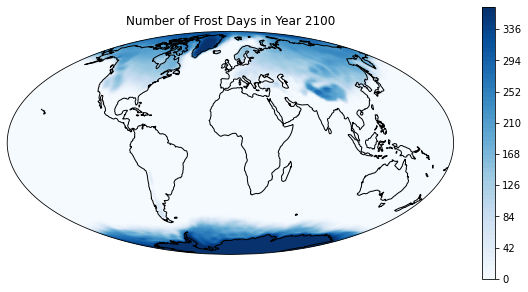

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

plt.contourf(lon, lat, ds_tasmin_year_count, 60,
            transform=ccrs.PlateCarree(),
            cmap='Blues')
ax.coastlines()
ax.set_global()

# Add a color bar
plt.colorbar(ax=ax)
plt.title('Number of Frost Days in Year ' +year)
plt.show()